In [23]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
#from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine


from meshGen import mesh2DLaminates

In [24]:
lambda1 = 1
lambda2 = 1000

order0 = 2

In [25]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.1



rotated = True



## 3. All together
### 3.1. Reference Solution 

In [26]:
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=maxh_edges, fullProblemX=True, rotated=rotated, modelHalfAir=False, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

Boundaries {'top', 'left', 'right', 'itop', 'bottom', 'ibottom', 'ileft', 'iright'}
Materials {'inner', 'insulation', 'outer'}


In [27]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 4.079175163188973     
CG iteration 2, residual = 3.7534611013716286e-14     


In [28]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( Norm(-grad(sol_ref)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
Draw(lam* Norm(-grad(sol_ref)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)


energy:	0.025518002777672882


### 3.2 Multiscale 

In [29]:
import cempy as cp
modelHalfAir=False
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=False, domainNameHalfAir="multiscale", maxh_edges=maxh_edges, rotated=rotated, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
Draw(meshMS.ngmesh)


from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)


('outer', 'outer', 'multiscale', 'gap', 'gap')


In [30]:
import importlib
import MS_helper_functions as ms
ms = importlib.reload(ms)
cl_Phi = ms.cl_Phi

getIntegrand4BFI = ms.getIntegrand4BFI
gradgradMS = ms.gradgradMS
pyLobatto = ms.pyLobatto
pydxLobatto = ms.pydxLobatto



In [45]:


cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 1 if rotated else 0

if False:
    from cempy.phiFunctions import Lobatto, dxLobatto
    cl_Phi.phiFunction = Lobatto
    cl_Phi.dzPhiFunction = dxLobatto
else:
    cl_Phi.phiFunction = pyLobatto
    cl_Phi.dzPhiFunction = pydxLobatto



def calcMultiscale(useGradients=True, drawPhis=True):

    roughbnd = "left|right" if rotated else "top|bottom"
    smoothbnd = "itop|ibottom" if rotated else "ileft|iright"

    # microshape functions
    orderPhi = [
            cl_Phi(1, fes_order=2, material="multiscale|gap", dirichlet=roughbnd, useGradients=True, useAbsolutes=True), 

            cl_Phi(2, fes_order=2, material="multiscale|gap", dirichlet=roughbnd, inAir=False, useGradients=True), 
            cl_Phi(2, fes_order=2, material="multiscale|gap", dirichlet=roughbnd, inIron=False, useGradients=True), 

            # cl_Phi(4, fes_order=1, material="multiscale|gap", dirichlet=roughbnd, useGradients=True, inAir=False, modelHalfAir=False), 
            # cl_Phi(4, fes_order=1, material="multiscale|gap", dirichlet=roughbnd, useGradients=True, inIron=False, modelHalfAir=False), 
        ]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi, nFig=1)

    VSpace = []
    # # u0 
    VSpace.append(H1(meshMS, order=order0, dirichlet="left|right")) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True, secondOrder=True)

    a = BilinearForm(VSpace, symmetric=False)
    f = LinearForm(VSpace)

    a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True) * dx("multiscale")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda1, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True) * dx("gap")


    trials = cl_gradgradMS.trials
    tests = cl_gradgradMS.tests

    h = specialcf.mesh_size
    n = specialcf.normal(meshMS.dim)
    alpha = 10
    # couple u
    if True:
        #[u][v]
        a += alpha*order0**2/h  * getIntegrand4BFI(cl_gradgradMS.u, cl_gradgradMS.v,  1, 1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * getIntegrand4BFI(cl_gradgradMS.u, [cl_gradgradMS.v[0]],  1, 1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += alpha*order0**2/h  * getIntegrand4BFI([cl_gradgradMS.u[0]], [cl_gradgradMS.v[0]],  1, 1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * getIntegrand4BFI([cl_gradgradMS.u[0]], cl_gradgradMS.v,  1, 1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)


    if True:
        #{dn u } [ v]
        a += -getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, cl_gradgradMS.v,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, [cl_gradgradMS.v[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], cl_gradgradMS.v,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += -getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], [cl_gradgradMS.v[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        
        #[ u] {dn v } 
        a += -getIntegrand4BFI(cl_gradgradMS.u, cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += getIntegrand4BFI(cl_gradgradMS.u, [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += getIntegrand4BFI([cl_gradgradMS.u[0]], cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += -getIntegrand4BFI([cl_gradgradMS.u[0]], [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)




    # couple fluxes
    if True:
        # [dn u] [ dn v]
        a += alpha*order0**2/h  * getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += alpha*order0**2/h  * getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)


    # couple hesse 
    if True:

        #{gradgrad(u)_n_n } [ dn v]
        a += -getIntegrand4BFI(cl_gradgradMS.hesse_u_trace_nn, cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += getIntegrand4BFI(cl_gradgradMS.hesse_u_trace_nn, [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += getIntegrand4BFI([cl_gradgradMS.hesse_u_trace_nn[0]], cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += -getIntegrand4BFI([cl_gradgradMS.hesse_u_trace_nn[0]], [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)


        #[ dn u] {gradgrad(v)_n_n } 
        a += -getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, cl_gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], cl_gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, [cl_gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)
        a += -getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], [cl_gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds(smoothbnd)


    prec = Preconditioner(a,type="direct") 


    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    print(cl_Phi.orientation)
    return sol, cl_gradgradMS.sol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, cl_gradgradMS = calcMultiscale(False, drawPhis=False)
H_MS = sum(H_comp)
H_MS.Compile()
print(energy_ref, energy_MS)
# print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))


CG iteration 1, residual = 8.018110143246018     
CG iteration 2, residual = 1.2855106887847515e-13     
1
0.025518002777672882 0.026969025601744922


In [46]:
print(f"energy:\t{energy_MS}")
Draw(sum(sol_comp_MS), meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
# Draw( Norm(H_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
# Draw( lam * Norm(H_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)

energy:	0.026969025601744922


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 1.3 Comparison 

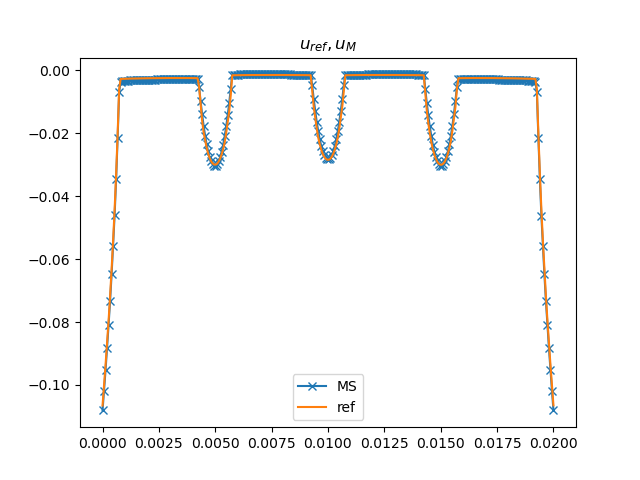

In [47]:

start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02


plt.figure(2)
start = -d/2
end = d/2

pnt1 = [-d/2*0.99, start, 0] if rotated else [start, -d/2*0.99, 0]
pnt2 = [-d/2*0.99, end, 0] if rotated else [end, -d/2*0.99, 0]


evalOnLine(sum(sol_comp_MS) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=300);
evalOnLine(sol_ref , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 300, title=r"$u_{ref}, u_{M}$");


plt.legend()
plt.show()

In [48]:
# from ngsolve.webgui import Draw
Draw(H_MS[0] ,meshRef, fastdraw=True)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

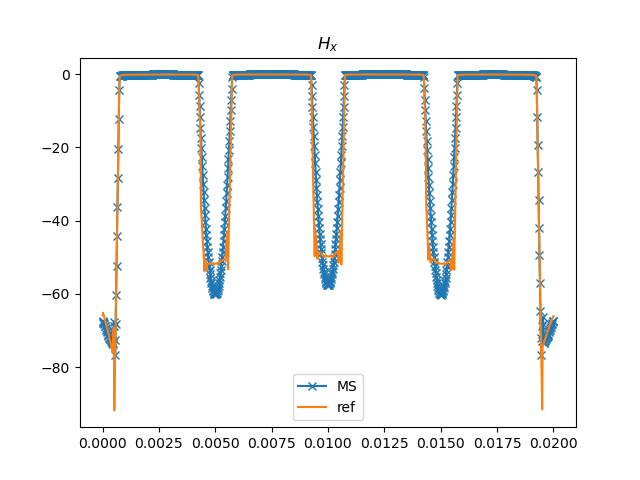

In [49]:
start = -d/2
end = d/2

plt.figure(3)
evalOnLine(H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_x$");



plt.legend()
plt.show()

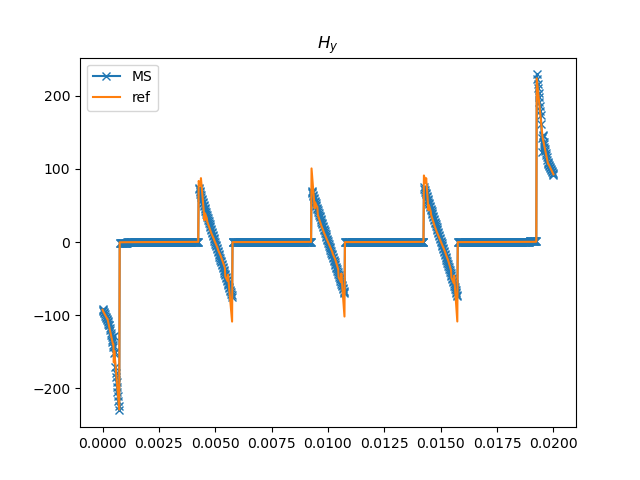

In [50]:
start = -d/2
end = d/2


plt.figure(4)

evalOnLine(H_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_y$");
plt.legend()
plt.show()

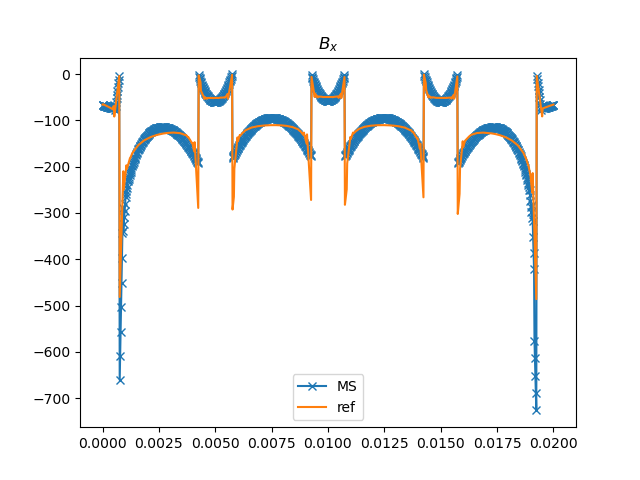

In [51]:
start = -d/2
end = d/2


plt.figure(5)
evalOnLine(lam * H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# evalOnLine(lam * (H_comp[0])[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=1000);
evalOnLine(-lam * grad(sol_ref)[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_x$");

plt.legend()
plt.show()

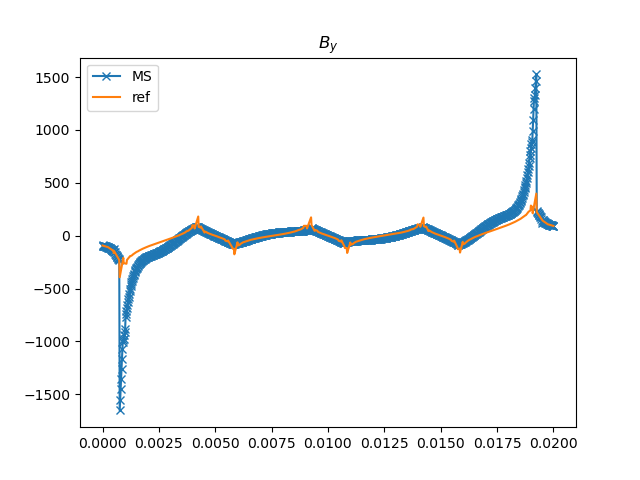

In [52]:
start = -d/2
end = d/2

plt.figure(6)
evalOnLine(lam * H_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# evalOnLine(lam * (H_comp[0])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=1000);

evalOnLine(-lam * grad(sol_ref)[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_y$");

plt.legend()
plt.show()

In [39]:
print(f"energy:\t{energy_MS}")
Draw(IfPos(y, sol_ref, sum(sol_comp_MS)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})


energy:	0.02696902560176005


In [40]:
Draw(IfPos(y, -grad(sol_ref), H_MS)[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=50, min = -50)
Draw(IfPos(y, -grad(sol_ref), H_MS)[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=50, min = -50)

In [41]:
Draw(lam * IfPos(y, -grad(sol_ref), H_MS)[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
Draw(lam * IfPos(y, -grad(sol_ref), H_MS )[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
lamMS = IfPos(cl_Phi(0, 0, inIron=False, material="multiscale").phi, lambda1, lambda2)

# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[0], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[1], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)

In [42]:
print(type(cl_gradgradMS.gradsol_pack[0][1]))

<class 'MS_helper_functions.pyLobatto'>


In [43]:
print("Norm soll diff", Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")



Norm soll diff 7.162502919202532e-07
diff energy 0.02696902560176005 0.025518002777672882 0.0014510228240871663 5.686271126816973 %


In [44]:
from ngsolve.webgui import Draw


a = cl_Phi(3, 0)
b = a.phi
c = b.fun[0]
d = CF()
type(c)

# Draw(IfPos(x, a.dzphi, c), meshRef)



TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. ngsolve.fem.CoefficientFunction(arg0: dict)
    2. ngsolve.fem.CoefficientFunction(coef: object, dims: Optional[tuple] = None)

Invoked with: 

In [ ]:
from ngsolve.webgui import Draw

a = cl_Phi(2, 0).phi.getDiff()
b = cl_Phi(2, 0).dzphi

Draw(IfPos(x, a, b), meshRef)

UnboundLocalError: local variable 'coordinate' referenced before assignment

In [ ]:
from ngsolve.webgui import Draw
settings={"Objects":{"Wireframe":False}, "deformation": False}
order = 2

mask = meshRef.MaterialCF({"outer":0}, default=1)
Draw(mask * IfPos(x, cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).phi.getDiff(), 
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).dzphi), meshRef, 
                settings = settings)

for order in [0, 1, 2, 3, 4]:
    print(order, Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).phi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).phi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "_Fe", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inAir=False).phi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inAir=False).phi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "_0", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inIron=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inIron=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    
    print(order, "dz", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))

    print(order, "dz_Fe", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inAir=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inAir=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "dz_0", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inIron=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inIron=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))

    print("=============0")

/usr/lib/python3/dist-packages/sympy/core/sympify.py:456: SymPyDeprecationWarning: 

String fallback in sympify has been deprecated since SymPy 1.6. Use
sympify(str(obj)) or sympy.core.sympify.converter or obj._sympy_
instead. See https://github.com/sympy/sympy/issues/18066 for more
info.

  ).warn()


SympifyError: Sympify of expression 'could not parse '<function pyLobatto.__init__.<locals>.<lambda> at 0x7ff8183983a0>'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)